Best viewed locally in a Jupyter notebook or online in <a href="https://nbviewer.jupyter.org/github/codykingham/noun_semantics/blob/master/analysis.ipynb">Jupyter Notebook Viewer</a>

# Analysis of Noun Semantics in the Hebrew Bible
## Cody Kingham

In this notebook, I compare the syntactic contexts of the top 200 most frequent nouns in the Hebrew Bible. This notebook essentially walks through my process and includes limited commentary throughout. Full descriptions borrowed from the paper will soon be transferred to here as well.

In [1]:
! echo "last updated:"; date

In [2]:
from pathlib import Path

# ETCBC's BHSA data
from tf.fabric import Fabric
from tf.app import use

# stats & data-containers
import collections, math, re, random, csv
import pandas as pd
pd.set_option('display.max_rows', 100)
import numpy as np
from kneed import KneeLocator # https://github.com/arvkevi/kneed

# data visualizations
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.serif'] = ['Times New Roman']
from bidi.algorithm import get_display

from IPython.display import HTML, display, Image
from adjustText import adjust_text # fixes overlapping scatterplot annotations

# custom modules
from pyscripts.contextparameters import deliver_params
from pyscripts.deliver_data import deliver_data
from pyscripts.pca import apply_pca, plot_PCA
import pyscripts.significance as my_stats

# prep the Hebrew syntax data
name = 'noun_semantics'
hebrew_data = ['~/github/etcbc/{}/tf/c'.format(direc) for direc in ('bhsa','lingo/heads', 'heads', 'phono')] # data dirs
load_features = '''
typ phono lex_utf8 lex
voc_lex_utf8 voc_lex gloss
freq_lex pdp sp ls
language
rela number function
vs vt
code label
head obj_prep sem_set nhead
heads noun_heads
''' 

# Text Fabric load statements
TF = Fabric(locations=hebrew_data)
api = TF.load(load_features)
B = use('bhsa', api=api, hoist=globals(), silent=True) # Bhsa functions for search and visualizing text

This is Text-Fabric 8.4.0
Api reference : https://annotation.github.io/text-fabric/cheatsheet.html

124 features found and 0 ignored
  0.00s loading features ...
   |     0.00s Dataset without structure sections in otext:no structure functions in the T-API
  8.94s All features loaded/computed - for details use loadLog()


In [3]:
# configure paths for figures and data
plot_path = Path('results/plots/')
table_path = Path('results/tables')
fisher_data = table_path.joinpath('fisher_scores.csv')

def savefig(name):
    plt.savefig(plot_path.joinpath(name), format='svg', bbox_inches='tight')
def savecsv(name, df):
    df.to_csv(table_path.joinpath(name))

In [4]:
def reverse_hb(heb_text):
    '''
    Reverses order of left-to-right text 
    for good matplotlib formatting.
    '''
    return ''.join(reversed(heb_text))

def show_word_list(word_nodes, joiner='&nbsp;&nbsp;|', title=''):
    '''
    Displays Hebrew for a pipe-separated list of word nodes
    Good for seeing lexemes without taking up screen space.
    '''
    formatted = joiner.join(T.text(node) for node in word_nodes)
    display(HTML(formatted))
    
def show_subphrases(phrase, direction=L.d):
    '''
    A simple function to print subphrases
    and their relations to each other.
    '''
    for sp in direction(phrase, 'subphrase'):
        
        mother = E.mother.f(sp)[0] if E.mother.f(sp) else ''
        mother_text = T.text(mother)
        
        print('-'*7 + str(sp) + '-'*16)
        print()
        print(f'{T.text(sp)} -{F.rela.v(sp)}-> {mother_text}')
        print(f'nodes:  {sp} -{F.rela.v(sp)}-> {mother}')
        print(f'slots:  {L.d(sp, "word")} -{F.rela.v(sp)}-> {L.d(mother or 0, "word")}')
        print('-'*30)

## Corpus Size

Below is the number of words included in the corpus of BHSA.

In [5]:
len(list(F.otype.s('word')))

426584

## Define a Target Noun Set

*Insert discussion about the semantic relationship between iconicity and frequency with regards to the most frequent noun lexemes in the HB.*

In [6]:
raw_search = '''

lex language=Hebrew sp=subs

'''

raw_nouns = B.search(raw_search)

  0.02s 3706 results


Now we order the results on the basis of lexeme frequency.

In [7]:
raw_terms_ordered = sorted(((F.freq_lex.v(res[0]), res[0]) for res in raw_nouns), reverse=True)

Below we have a look at the top 50 terms from the selected set. Pay attention to the feature `ls`, i.e. "lexical set." This feature gives us some rudimentary semantic information about the nouns and their usual functions, and it suggests that some additional restrictions are necessary for the noun selection procedure. Note especially that several of these nouns are used in adjectival or prepositional roles (e.g.  כל ,אחד, אין, תחת).

In [8]:
raw_nnodes = [res[1] for res in raw_terms_ordered] # isolate the word nodes of the sample
B.displaySetup(extraFeatures={'ls', 'freq_lex'}) # config B to display ls and freq_lex

# display lexeme data
for i, node in enumerate(raw_nnodes[:50]):
    print(T.text(node), end=' | ')

כֹּל  | בֵּן  | אֱלֹהִים  | מֶלֶךְ  | אֶרֶץ  | יֹום  | אִישׁ  | פָּנֶה  | בַּיִת  | עַם  | יָד  | דָּבָר  | אָב  | עִיר  | אֶחָד  | עַיִן  | שָׁנָה  | שֵׁם  | עֶבֶד  | אַיִן  | אִשָּׁה  | שְׁנַיִם  | נֶפֶשׁ  | כֹּהֵן  | אַחַר  | דֶּרֶךְ  | אָח  | שָׁלֹשׁ  | לֵב  | רֹאשׁ  | בַּת  | מַיִם  | מֵאָה  | הַר  | גֹּוי  | אָדָם  | חָמֵשׁ  | קֹול  | תַּחַת  | פֶּה  | אֶלֶף  | עֹוד  | שֶׁבַע  | צָבָא  | קֹדֶשׁ  | אַרְבַּע  | עֹולָם  | מִשְׁפָּט  | שַׂר  | שָׁמַיִם  | 

Based on the nouns that are present, we should make some key exclusions. Many substantives have more functional or adjectival roles. Undesirable categories include copulative nouns (`nmcp`, e.g. אין), cardinal numbers (`card`), potential prepositions (`ppre`, e.g. תחת). The `ls` category of potential adverb (`padv`) contains desirable nouns like יום, but also more functionally adverbial-nouns like עוד. Thus we can see that there is a range of adverbial tendencies found in this category. Due to the potentially interesting possibility of seeing these tendencies play out in the data, we can decide to keep these instances. 

To be sure, the very phenomenon of "functional" versus "nominal" is worthy of further, quantitative investigation. The `ls` feature is an experimental and incomplete feature in the ETCBC, and this is precisely the kind of shortcoming this present work seeks to address. Nouns and adverbs likely sit along a sliding scale of adverbial tendencies, with adverbs nearly always functioning in such a role, and nouns exhibiting various statistical tendencies. But due to the scope of this investigation, we limit ourselves to mainly nominal words with a small inclusion of some adverbial-like substantives.

We can eliminate more functional nouns by restricting the possible lexical set (`ls`) values. Below we apply those restrictions to the search template. In the case of certain quantifiers such as כל there is an `ls` feature of distributive noun (`nmdi`), yet this feature is likewise applied to nouns such as אח ("brother"). So it is undesirable to exclude all of these cases. Thus we depend, instead, on an additional filter list that excludes quantifiers.

A few terms such as דרך and עבר are eliminated because the ETCBC labels it as a potential preposition. This is a speculative classification. So we define a seperate parameter in the template that saves this instance.

In [9]:
exclude = '|'.join(('KL/', 'M<V/', 'JTR/', 'M<FR/', 'XYJ/')) # exclude quantifiers
include = '|'.join(('padv', 'nmdi'))  # ok ls features
keep = '|'.join(('DRK/', '<BR/'))

'''
Below is a TF search query for three cases:
One is a lexeme with included ls features.
The second is a lexeme with a null ls feature.
The third is lexemes we want to prevent from being excluded.
For all cases we exclude excluded lexemes.
'''

select_noun_search = f'''

lex language=Hebrew
/with/
sp=subs ls={include} lex#{exclude}
/or/
sp=subs ls# lex#{exclude}
/or/
sp=subs lex={keep}
/-/

'''

select_nouns = B.search(select_noun_search)
noun_dat_ordered = sorted(((F.freq_lex.v(res[0]), res[0]) for res in select_nouns), reverse=True)
nnodes_ordered = list(noun_dat[1] for noun_dat in noun_dat_ordered)
filtered_lexs = list(node for node in raw_nnodes if node not in nnodes_ordered)

print(f'\t{len(raw_nouns) - len(select_nouns)} results filtered out of raw noun list...')
print('\tfiltered lexemes shown below:')
show_word_list(filtered_lexs)

  0.02s 3658 results
	48 results filtered out of raw noun list...
	filtered lexemes shown below:


### Plot the Nouns in Order of Frequency

Now that we have obtained a filtered noun-set, we must decide a cut-off point at which to limit the present analysis. Below we plot the attested nouns and their respective frequencies.

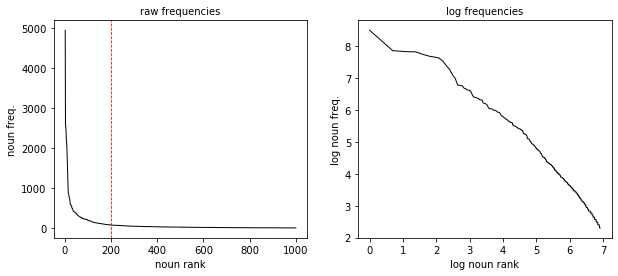

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
y_freqs = [lex_data[0] for lex_data in noun_dat_ordered]
x_rank = [i+1 for i in range(0, len(y_freqs))]

# second plot
ax1.plot(x_rank[:1000], y_freqs[:1000], color='black', linewidth=1)
ax1.set_xlabel('noun rank', size=10)
ax1.set_ylabel('noun freq.', size=10)
ax1.axvline(200, color='red', linewidth=0.8, linestyle='--')
ax1.set_title('raw frequencies', size=10)

# second plot log x log
ax2.plot(np.log(x_rank[:1000]), np.log(y_freqs[:1000]), color='black', linewidth=1)
ax2.set_xlabel('log noun rank', size=10)
ax2.set_ylabel('log noun freq.', size=10)
ax2.set_title('log frequencies', size=10)
savefig('noun_frequencies1-1000.svg')

These curves are typical of Zipf's law:

> Zipf's law states that given some corpus of natural language utterances, the frequency of any word is inversely proportional to its rank in the frequency table ([wikipedia](https://en.wikipedia.org/wiki/Zipf%27s_law))

The curve sharply "elbows" at around rank 15. Between ranks 50-100 there is still an appreciable drop-off. The curve starts to significantly flatten after 200. We thus decide an arbitrary cut-off point at rank 200, based on the fact that the curve does not show any significant leveling after this point.

In [11]:
target_nouns = nnodes_ordered[:200]
tnoun_instances = set(word for lex in target_nouns for word in L.d(lex, 'word'))

show_word_list(target_nouns) # temporary comment out while bug is fixed
print(f'\n{len(tnoun_instances)} nouns ready for searches')


73991 nouns ready for searches


In [12]:
nouns_text_freqs = sorted(
    ((F.voc_lex_utf8.v(L.d(noun,'word')[0]), F.freq_lex.v(noun)) 
         for noun in target_nouns), key=lambda k: k[-1], reverse=True
)

In [13]:
', '.join(f'{noun}' for noun, freq in nouns_text_freqs)

'בֵּן, אֱלֹהִים, מֶלֶךְ, אֶרֶץ, יֹום, אִישׁ, פָּנֶה, בַּיִת, עַם, יָד, דָּבָר, אָב, עִיר, עַיִן, שָׁנָה, שֵׁם, עֶבֶד, אִשָּׁה, נֶפֶשׁ, כֹּהֵן, דֶּרֶךְ, אָח, לֵב, רֹאשׁ, בַּת, מַיִם, הַר, גֹּוי, אָדָם, קֹול, פֶּה, עֹוד, צָבָא, קֹדֶשׁ, עֹולָם, מִשְׁפָּט, שַׂר, שָׁמַיִם, תָּוֶךְ, חֶרֶב, כֶּסֶף, מִזְבֵּחַ, מָקֹום, יָם, זָהָב, אֵשׁ, רוּחַ, נְאֻם, שַׁעַר, דָּם, אֹהֶל, סָבִיב, אָדֹון, עֵץ, כְּלִי, שָׂדֶה, נָבִיא, רָעָה, מִלְחָמָה, מְאֹד, לֶחֶם, עֵת, חַטָּאת, עֹלָה, חֹדֶשׁ, בְּרִית, אַף, פַּרְעֹה, צֹאן, אֶבֶן, מִדְבָּר, בָּשָׂר, מַטֶּה, לֵבָב, רֶגֶל, אַמָּה, חֶסֶד, חַיִל, נַעַר, גְּבוּל, שָׁלֹום, אֵל, מַעֲשֶׂה, עָוֹן, זֶרַע, קֶרֶב, לַיְלָה, בַּד, נַחֲלָה, אֲדָמָה, מֹועֵד, תֹּורָה, אֵם, בֶּגֶד, מַחֲנֶה, בֹּקֶר, מַלְאָךְ, מִנְחָה, אֲרֹון, כָּבֹוד, חָצֵר, כַּף, שֶׁמֶן, שֵׁבֶט, בְּהֵמָה, מִשְׁפָּחָה, אֹזֶן, רֵעַ, סֵפֶר, בָּקָר, מִצְוָה, שָׂפָה, דֹּור, בַּעַל, חוּץ, פֶּתַח, אַיִל, זֶבַח, מָוֶת, גִּבֹּור, צְדָקָה, רֹב, צָפֹון, חָכְמָה, עֵדָה, חַיִּים, עֲבֹדָה, יַיִן, מַעַל, מִשְׁכָּן, נַחַל, יָמִין,

## Strategy for Context Selection

See [pyscripts/contextparameters.py](pyscripts/contextparameters.py) for the full delineation of these patterns and to see how they've been selected and tokenized. 

In [14]:
contexts = deliver_params(tnoun_instances, tf=api)
print('done!')

done!


In [15]:
context_data = deliver_data(contexts, tf=TF)

running query on template [ T.function→ st.verb.lex ]...
	19884 results found.
running query on template [ T.prep.funct→ st.verb.lex ]...
	15009 results found.
running query on template [ lex.PreC→ T.Subj ]...
	2525 results found.
running query on template [ lex.prep.PreC→ T.Subj ]...
	1136 results found.
running query on template [ T.PreC→ lex.Subj ]...
	930 results found.
running query on template [ T.prep.PreC→ lex.Subj ]...
	1504 results found.
running query on template [ lex.coord→ T ]...
	4217 results found.
running query on template [ T.coord→ lex ]...
	4336 results found.
running query on template [ lex.atr→ T ]...
	1588 results found.
running query on template [ lex.coord→ T (phrase atoms) ]...
	704 results found.
running query on template [ T.coord→ lex (phrase atoms) ]...
	600 results found.
running query on template [ lex.appo→ T ]...
	1410 results found.
running query on template [ T.appo→ lex ]...
	3640 results found.


Let's have a look at the first example...

In [16]:
context_data[0]

{'clause': 427553,
 'book': 'Gen',
 'ref': 'Gen 1:1',
 'clause_text': 'בְּרֵאשִׁ֖ית בָּרָ֣א אֱלֹהִ֑ים אֵ֥ת הַשָּׁמַ֖יִם וְאֵ֥ת הָאָֽרֶץ׃ ',
 'target': 'אלהים.n1',
 'target_node': 4,
 'basis': 'T.Subj→ ברא.v1.qal',
 'basis_nodes': (3, 651544),
 'verse_text': 'בְּרֵאשִׁ֖ית בָּרָ֣א אֱלֹהִ֑ים אֵ֥ת הַשָּׁמַ֖יִם וְאֵ֥ת הָאָֽרֶץ׃ ',
 'context_type': 'T.function→ st.verb.lex',
 'function': 'Subj'}

Now we put the data into a dataframe. We also export the dataframe for reference.

In [20]:
data_df = pd.DataFrame(context_data)
data_df.set_index('clause', inplace=True)
data_df.to_csv('dataset.csv') # export dataset
data_df.head()

,book,ref,clause_text,target,target_node,basis,basis_nodes,verse_text,context_type,function
clause,,,,,,,,,,
427553,Gen,Gen 1:1,בְּרֵאשִׁ֖ית בָּרָ֣א אֱלֹהִ֑ים אֵ֥ת הַשָּׁמַ֖י...,אלהים.n1,4,T.Subj→ ברא.v1.qal,"(3, 651544)",בְּרֵאשִׁ֖ית בָּרָ֣א אֱלֹהִ֑ים אֵ֥ת הַשָּׁמַ֖י...,T.function→ st.verb.lex,Subj
427553,Gen,Gen 1:1,בְּרֵאשִׁ֖ית בָּרָ֣א אֱלֹהִ֑ים אֵ֥ת הַשָּׁמַ֖י...,שׁמים.n1,7,T.Objc→ ברא.v1.qal,"(3, 651545)",בְּרֵאשִׁ֖ית בָּרָ֣א אֱלֹהִ֑ים אֵ֥ת הַשָּׁמַ֖י...,T.function→ st.verb.lex,Objc
427553,Gen,Gen 1:1,בְּרֵאשִׁ֖ית בָּרָ֣א אֱלֹהִ֑ים אֵ֥ת הַשָּׁמַ֖י...,ארץ.n1,11,T.Objc→ ברא.v1.qal,"(3, 651545)",בְּרֵאשִׁ֖ית בָּרָ֣א אֱלֹהִ֑ים אֵ֥ת הַשָּׁמַ֖י...,T.function→ st.verb.lex,Objc
427557,Gen,Gen 1:3,וַיֹּ֥אמֶר אֱלֹהִ֖ים,אלהים.n1,34,T.Subj→ אמר.v1.qal,"(33, 651559)",וַיֹּ֥אמֶר אֱלֹהִ֖ים יְהִ֣י אֹ֑ור וַֽיְהִי־אֹֽ...,T.function→ st.verb.lex,Subj
427560,Gen,Gen 1:4,וַיַּ֧רְא אֱלֹהִ֛ים אֶת־הָאֹ֖ור,אלהים.n1,42,T.Subj→ ראה.v1.qal,"(41, 651567)",וַיַּ֧רְא אֱלֹהִ֛ים אֶת־הָאֹ֖ור כִּי־טֹ֑וב וַי...,T.function→ st.verb.lex,Subj


Now we'll build the co-occurrence counts.

In [29]:
raw_counts = pd.pivot_table(
    data_df, 
    index='target', 
    columns='basis', 
    fill_value=0,
    aggfunc='size'
)

# sort by size, first by noun sum, then by basis sum
raw_counts = raw_counts.loc[raw_counts.sum(1).sort_values(ascending=False).index]
raw_counts = raw_counts[raw_counts.sum().sort_values(ascending=False).index]

raw_counts.head()

basis,T.appo→ יהוה.n1,T.Objc→ נתן.v1.qal,T.Objc→ עשׂה.v1.qal,T.coord→ בן.n1,T.Objc→ לקח.v1.qal,T.Subj→ אמר.v1.qal,T.Subj→ בוא.v1.qal,T.ל.Cmpl→ נתן.v1.qal,T.Objc→ נשׂא.v1.qal,T.Objc→ שׂים.v1.qal,...,T.ל.Adju→ יחל.v1.hif,T.ל.Adju→ ידע.v1.hif,T.ל.Adju→ חרם.v1.hif,T.ל.Adju→ טמן.v1.qal,T.ל.Adju→ טהר.v1.qal,T.ל.Adju→ חתר.v1.qal,T.ל.Adju→ חשׂף.v1.qal,T.ל.Adju→ חשׂך.v1.qal,T.ל.Adju→ חרץ.v1.qal,T.Adju→ אכל.v1.pual
target,,,,,,,,,,,,,,,,,,,,,
בן.n1,0,15,1,288,23,24,34,32,4,2,...,0,0,0,0,0,0,0,0,1,0
מלך.n1,2,10,0,1,1,127,28,13,0,5,...,0,0,0,0,0,0,0,0,0,0
ארץ.n1,0,61,11,0,8,1,2,1,0,5,...,0,0,0,0,0,0,0,0,0,0
אלהים.n1,730,4,9,0,1,50,8,4,0,2,...,0,0,0,0,0,0,0,0,0,0
אישׁ.n1,0,6,1,5,24,42,34,14,0,1,...,0,0,0,0,0,0,0,0,0,0


## Removing Outliers

We will apply two primary adjustments:

1. We drop co-occurrences that are unique to a noun. The dropped observations will thus be considered outliers. While these items are useful for describing the uniqueness of a given lexeme, they are unhelpful for drawing comparisons between our sets. 
2. We convert the counts into a measure of statistical significance. For this we use Fisher's exact test, which is ideal for datasets that have counts that are less than 5. Our matrix is likely to have many such counts. The resulting p-values, of which <0.05 represents a statistically significant colexeme, will be log-transformed. Values that fall below expected frequencies will be negatively transformed.

In [30]:
raw_counts.sum(1).sort_values().head(10)

target
נאם.n1       7
פאה.n1      25
מספר.n1     29
רב.n2       29
קדם.n1      37
מעל.n1      40
שׁקר.n1     43
תמיד.n1     43
מלכות.n1    43
עבר.n1      45
dtype: int64

We note that the term נאם only occurs 7 times in the entire dataset<br>
compared with the other terms. We will therefore drop that term due to<br>
a lack of representative examples.

### Remove Co-occurrence Outliers

We will remove colexemes/bases that occur with only one target noun. This is done by subtracting<br> 
the row total from each item in the row. Any 0 value in a row means that that row has a unique <br>
colexeme that only occurs with one target noun (we will call that a `hapax_colex` here). We will<br>
remove these rows further down.

### Drop the outliers

In [31]:
# drop נאם and any context counts left empty as a result
count_df = raw_counts.drop('נאם.n1', axis=0)
empties = count_df.loc[:, (count_df == 0).all(0)]
count_df = count_df.drop(empties.columns, axis=1)

# drop all hapax legomena
colex_counts = count_df.sum(0)
remaining_counts = count_df.sub(colex_counts, axis=1) # subtract colex_counts
hapax_colex = remaining_counts.loc[:,(remaining_counts == 0).any(0)] # select columns that have a 0 value anywhere
count_df = count_df.drop(labels=hapax_colex.columns, axis=1)

print(f'New data dimensions: {count_df.shape}')
print(f'New total observations: {count_df.sum().sum()}')
print(f'Observations removed: {raw_counts.sum().sum() - count_df.sum().sum()}')

New data dimensions: (199, 4045)
New total observations: 45424
Observations removed: 12059


Let's look at the sorted minimum values to make sure no terms have been left featureless.

In [32]:
count_df.sum().sort_values().head(5)

basis
T.Subj→ כסה.v1.hit     2
T.Time→ נגשׁ.v1.hif    2
T.Time→ נהג.v1.piel    2
T.coord→ כסא.n1        2
T.Time→ נוס.v1.qal     2
dtype: int64

In [33]:
count_df.sum(1).sort_values().head(5)

target
מספר.n1    19
פאה.n1     20
שׁקל.n1    20
רב.n2      21
קדם.n1     23
dtype: int64

### How many zero counts are there?

The raw count matrix has a lot of sparsity. Here's how many zeros there are. We also count other values.

In [34]:
# unique_values, value_counts = np.unique(data.values, return_counts=True)
# unique_counts = pd.DataFrame.from_dict(dict(zip(unique_values, value_counts)), orient='index', columns=['count'])
# display(HTML('<h5>Top 10 Unique Values and Their Counts in Dataset</h5>'))
# unique_counts.head(10)

In [35]:
# zero = unique_counts.loc[0.0][0]
# non_zero = unique_counts[unique_counts.index > 0].sum()[0]
# non_zero_ratio, zero_ratio = non_zero / (non_zero+zero), zero / (non_zero+zero)

# print(f'Number of zero count variables: {zero} ({round(zero_ratio, 2)})')
# print(f'Number of non-zero count variables: {non_zero} ({round(non_zero_ratio, 2)})')

Below the number of observed counts is given:

In [36]:
count_df.sum().sum()

45424

## Data Distribution

The basic unit of analysis is the level of the clause. We have selected a <br>
subset of all clauses from the Hebrew Bible. Let's see if the observed <br>
frequencies within the dataset exist above or below the expected frequencies.<br>
If they are below, then how much so?

In [37]:
from pyscripts.feature_formatting import book2sbl

In [38]:
all_clauses = collections.Counter()
for cl in F.otype.s('clause'):
    lang = F.language.v(L.d(cl,'word')[0])
    if lang != 'Hebrew':
        continue
    book, chapter, verse = T.sectionFromNode(cl)
    book = book2sbl[book]
    all_clauses[book] += 1
expected_freq = pd.Series(all_clauses)
expected_freq.head()

Gen     5987
Exod    4326
Lev     3077
Num     3925
Deut    3859
dtype: int64

In [39]:
# get samples from dataset
sample_df = data_df.loc[
    (data_df.target.isin(count_df.index)) & (data_df.basis.isin(count_df.columns))
]

In [40]:
# calculate deviation of proportions (Gries 2008; Levshina 2015)
# for observed frequencies, we only want to consider each clause once
# thus we create a dataframe that only keeps the first clause entry
non_duplicated_clauses = sample_df[~sample_df.index.duplicated(keep='first')]
observed_freq = non_duplicated_clauses.book.value_counts()
observed_prop = observed_freq.div(observed_freq.sum())
expected_prop = expected_freq.div(expected_freq.sum())
deviation_prop = observed_prop - expected_prop

Let's compare the overall number of clauses with observed clauses.

In [41]:
# overall clauses
expected_freq.sum()

86828

In [42]:
# observed clauses
observed_freq.sum()

28274

Let's make that a proportion...

In [43]:
observed_freq.sum() / expected_freq.sum()

0.32563228451651544

We see that our dataset consists of 32% of all clauses in the Hebrew Bible. This raises the<br>
further question. Have any particular books become over/under represented in the sample?<br>
We can answer this question by calculating the deviation of proportions (above), which tells<br>
how much the observed proportions differ from the expected proportions.<br>

In this case, let total number of clauses in the Hebrew Bible be $NC$ and let the total number<br>
of clauses in the sample be $SC$. We can obtain the deviation of proportions by doing the following:

[add formula]

### Plot Book Representations in Sample

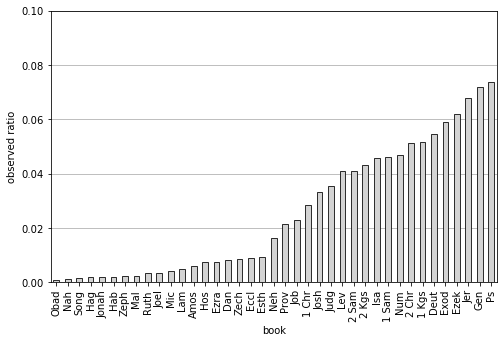

In [44]:
fig, ax = plt.subplots(figsize=(8, 5))

observed_prop.sort_values().plot(kind='bar', ax=ax, color='lightgrey', edgecolor='black', linewidth=0.8)
ax.grid(axis='y')
ax.set_axisbelow(True)
ax.axhline(0, color='black', linewidth=0.5)
ax.set_ylim((0, 0.1))
ax.set_ylabel('observed ratio')
ax.set_xlabel('book')

savefig('sample_book_proportions.svg')

### Plot deviated proportions in sample from expected proportion (entire Hebrew Bible)


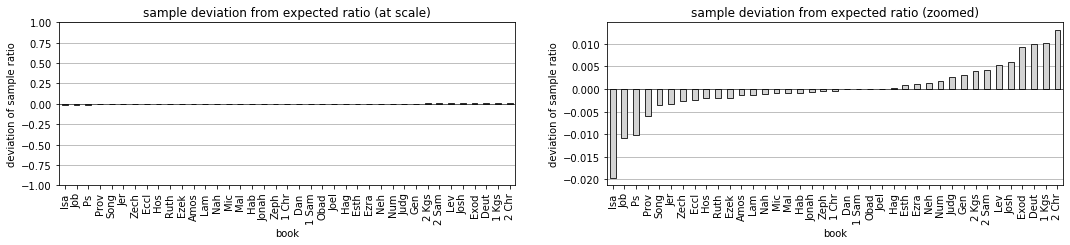

In [45]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 3))

for ax in (ax1, ax2):
    deviation_prop.sort_values().plot(kind='bar', ax=ax, color='lightgrey', edgecolor='black', linewidth=0.8)
    ax.grid(axis='y')
    ax.set_axisbelow(True)
    ax.axhline(0, color='black', linewidth=0.5)
    ax.set_ylabel('deviation of sample ratio')
    ax.set_xlabel('book')
    
ax1.set_title('sample deviation from expected ratio (at scale)')
ax1.set_ylim((-1, 1))
ax2.set_title('sample deviation from expected ratio (zoomed)')

savefig('sample_deviation_proportions.svg')

In [46]:
deviation_prop.sort_values().head(10)

Isa    -0.019670
Job    -0.010906
Ps     -0.010183
Prov   -0.006011
Song   -0.003519
Jer    -0.003377
Zech   -0.002677
Eccl   -0.002404
Hos    -0.002109
Ruth   -0.002043
dtype: float64

In [47]:
deviation_prop.sort_values(ascending=False).head(10)

2 Chr    0.013117
1 Kgs    0.010081
Deut     0.010023
Exod     0.009242
Josh     0.006033
Lev      0.005377
2 Sam    0.004239
2 Kgs    0.004062
Gen      0.003022
Judg     0.002626
dtype: float64

Here we see 2% underpresentation of Isaiah, as well as some smaller representation<br>
of Psalms, Job, and Proverbs.

In general, the underepresented portions are more poetic/prophetic in nature while more<br>
narratival books are represented very slightly higher.

Meanwhile there is a slightly higher sample of 2 Chronicles (1.3%) 1 Kings (1%) and Deuteronomy<br>
(1%).

These differences are very small, and thus we can say that the sample dataset is essentially as<br>
evenly distributed as the original sample across the Hebrew Bible.

## Context Type Distribution

Looking at the distribution of the various contexts

In [48]:
context_counts = sample_df.context_type.value_counts()
context_props = context_counts.div(context_counts.sum())

context_counts

T.function→ st.verb.lex        17539
T.prep.funct→ st.verb.lex      11216
T.coord→ lex                    3939
lex.coord→ T                    3778
T.appo→ lex                     2557
lex.PreC→ T.Subj                1330
lex.atr→ T                      1297
lex.appo→ T                      961
lex.coord→ T (phrase atoms)      643
T.prep.PreC→ lex.Subj            569
T.coord→ lex (phrase atoms)      565
lex.prep.PreC→ T.Subj            540
T.PreC→ lex.Subj                 490
Name: context_type, dtype: int64

In [49]:
context_props

T.function→ st.verb.lex        0.386117
T.prep.funct→ st.verb.lex      0.246918
T.coord→ lex                   0.086716
lex.coord→ T                   0.083172
T.appo→ lex                    0.056292
lex.PreC→ T.Subj               0.029280
lex.atr→ T                     0.028553
lex.appo→ T                    0.021156
lex.coord→ T (phrase atoms)    0.014156
T.prep.PreC→ lex.Subj          0.012526
T.coord→ lex (phrase atoms)    0.012438
lex.prep.PreC→ T.Subj          0.011888
T.PreC→ lex.Subj               0.010787
Name: context_type, dtype: float64

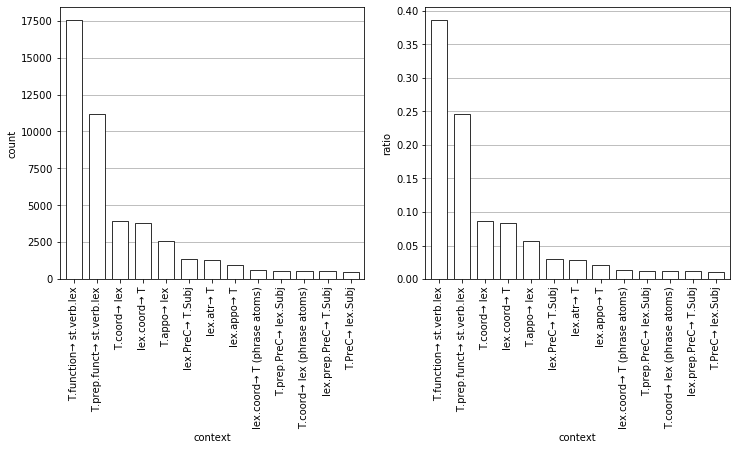

In [50]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

for ax, data in zip((ax1, ax2), (context_counts, context_props)):
    data.plot(kind='bar', ax=ax, color='white', edgecolor='black', linewidth=0.8, width=0.7)
    ax.grid(axis='y')
    ax.set_axisbelow(True)
    ax.axhline(0, color='black', linewidth=0.5)
    ax.set_xlabel('context')
    
ax1.set_ylabel('count')
ax2.set_ylabel('ratio')

savefig('context_counts.svg')

### Look at function distribution

In [51]:
function_count = sample_df.function.value_counts()
function_prop = function_count.div(function_count.sum())

function_count

Objc    9986
Cmpl    8328
Subj    6350
Adju    2104
Time    1188
Loca     536
Modi     248
PrAd      15
Name: function, dtype: int64

In [52]:
function_prop

Objc    0.347279
Cmpl    0.289619
Subj    0.220831
Adju    0.073170
Time    0.041315
Loca    0.018640
Modi    0.008625
PrAd    0.000522
Name: function, dtype: float64

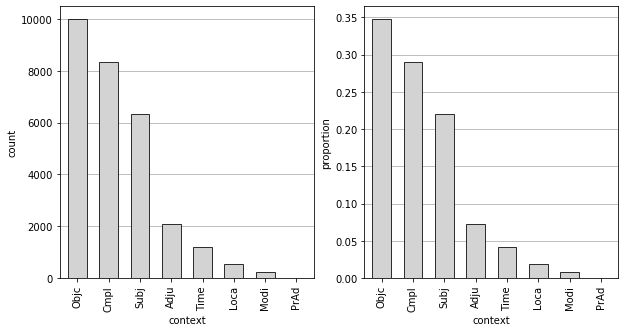

In [53]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

for ax, data in zip((ax1, ax2), (function_count, function_prop)):
    data.plot(kind='bar', ax=ax, color='lightgrey', edgecolor='black', linewidth=0.8, width=0.6)
    ax.grid(axis='y')
    ax.set_axisbelow(True)
    ax.axhline(0, color='black', linewidth=0.5)
    ax.set_xlabel('context')
    
ax1.set_ylabel('count')
ax2.set_ylabel('proportion')
savefig('function_counts.svg')

<hr>

#### Examining the Dataset

Below we look at the number of dimensions in the data:

In [54]:
count_df.shape

(199, 4045)

And number of observations..

In [55]:
count_df.size

804955

### Apply Fisher's Exact Test

Now we apply the Fisher's exact test to the data set. This involves supplying values to a 2x2 contingency table that is fed to `scipy.stats.fisher_exact`

#### Number of Datapoints To Iterate Over

The Fisher's exact test takes some time to run. That is because it must iterate over a lot of pairs. The number is printed below.

In [56]:
count_df.size

804955

#### Apply the Tests

The whole run takes 5.5-6.0 minutes on a 2017 Macbook pro.

In [60]:
run = False

In [58]:
if run:
    fisherdata, odds_ratios = my_stats.apply_fishers(count_df, sample_axis=0, feature_axis=1)
    fisherdata.to_csv(fisher_data)
else:
    fisherdata = pd.read_csv(fisher_data, index_col=0)
    odds_ratios = pd.read_csv('results/tables/fisher_odds.csv')

In [59]:
fisherdata.head(10)

,T.appo→ יהוה.n1,T.Objc→ נתן.v1.qal,T.Objc→ עשׂה.v1.qal,T.coord→ בן.n1,T.Objc→ לקח.v1.qal,T.Subj→ אמר.v1.qal,T.Subj→ בוא.v1.qal,T.ל.Cmpl→ נתן.v1.qal,T.Objc→ נשׂא.v1.qal,T.Objc→ שׂים.v1.qal,...,T.Subj→ יצג.v1.hof,T.Subj→ כאב.v1.qal,T.Subj→ כרע.v1.qal,T.מן.Cmpl→ תאר.v1.qal,T.מן.PreC→ הנה.Subj,T.מן.Time→ נפל.v1.hif,T.Subj→ כבס.v1.piel,צל.n1.ב.PreC→ T.Subj,קום.v1.PreC→ T.Subj,T.Subj→ כסה.v1.hit
בן.n1,-22.526176,-6.584308,-16.053631,185.876543,-0.664666,-0.530167,1.222394,1.975730,-4.095284,-5.308037,...,0.0,0.0,0.000000,0.0,0.881457,0.00000,0.000000,0.0,0.000000,0.0
מלך.n1,-8.520539,-2.325327,-8.723371,-6.924628,-5.273685,78.554862,3.889905,0.371990,-3.819261,-0.636749,...,0.0,0.0,1.164404,0.0,0.000000,0.00000,0.000000,0.0,0.000000,0.0
ארץ.n1,-10.090639,13.203858,-1.128023,-7.365759,-0.884072,-4.623685,-2.876729,-2.880341,-3.489125,-0.432857,...,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.000000,0.0,1.206016,0.0
אלהים.n1,inf,-5.609915,-2.204913,-8.241076,-5.270503,12.552682,-0.702842,-1.414605,-3.817084,-2.000357,...,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.000000,0.0,0.000000,0.0
אישׁ.n1,-10.062695,-3.578919,-6.751329,-3.087443,1.878527,9.497358,7.511183,0.870435,-3.481737,-2.408077,...,0.0,0.0,0.000000,0.0,0.000000,0.00000,1.203051,0.0,0.000000,0.0
יום.n1,-6.834724,-4.760392,-2.178418,-4.975213,-3.968938,-3.980369,1.349737,-2.632615,-2.280310,-2.085931,...,0.0,0.0,0.000000,0.0,0.000000,1.36321,0.000000,0.0,0.000000,0.0
עם.n1,-10.442296,-1.131739,-8.235782,-3.228429,-2.173060,4.546116,2.590030,0.733592,-1.845534,-1.277935,...,0.0,0.0,1.195437,0.0,0.000000,0.00000,0.000000,0.0,0.000000,0.0
בית.n1,-8.874304,-0.821262,-0.503675,-2.997220,-3.155937,-2.492384,-1.271517,0.139088,-3.152327,-1.420897,...,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.000000,0.0,0.000000,0.0
פנה.n1,-6.808889,-0.301747,-5.499925,-4.956384,-3.956114,-3.973536,-3.307627,24.424565,6.714989,7.676347,...,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.000000,0.0,0.000000,0.0
יד.n1,-8.013363,-0.680842,-6.337739,-6.014209,-4.628599,-4.652064,-2.871512,-3.147162,5.654060,1.344360,...,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.000000,0.0,0.000000,0.0


The Fisher's test has produced p-vales of 0, indicating a very high degree of attraction between lexemes and a colexemes. A log-transformed zero equals `infinity`. Below those values are isolated.

In [61]:
inf_nouns = fisherdata[(fisherdata == np.inf).any(1) | (fisherdata == -np.inf).any(1)]

inf_nouns

,T.appo→ יהוה.n1,T.Objc→ נתן.v1.qal,T.Objc→ עשׂה.v1.qal,T.coord→ בן.n1,T.Objc→ לקח.v1.qal,T.Subj→ אמר.v1.qal,T.Subj→ בוא.v1.qal,T.ל.Cmpl→ נתן.v1.qal,T.Objc→ נשׂא.v1.qal,T.Objc→ שׂים.v1.qal,...,T.Subj→ יצג.v1.hof,T.Subj→ כאב.v1.qal,T.Subj→ כרע.v1.qal,T.מן.Cmpl→ תאר.v1.qal,T.מן.PreC→ הנה.Subj,T.מן.Time→ נפל.v1.hif,T.Subj→ כבס.v1.piel,צל.n1.ב.PreC→ T.Subj,קום.v1.PreC→ T.Subj,T.Subj→ כסה.v1.hit
אלהים.n1,inf,-5.609915,-2.204913,-8.241076,-5.270503,12.552682,-0.702842,-1.414605,-3.817084,-2.000357,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In this case the Fisher's has returned a zero value. A p-value of 0 means that the likelihood אלהים and יהוה are *not* dependent variables is essentially null. We can thus reject the null hypothesis that the two values are not related. There is, rather, a maximum level of confidence that these two values *are* interrelated. The `np.inf` value that resulted from `log10(0)` is not viable for calculating vector distances. Thus, we need to substitute an arbitrary, but appropriate value. Below we access the lowest non-zero p-values in the dataset.

In [62]:
fisherdata.max().sort_values(ascending=False)

T.appo→ יהוה.n1                 inf
T.ב.Cmpl→ שׁמע.v1.qal    188.586441
T.coord→ שׁנה.n1         185.878689
T.coord→ בן.n1           185.876543
T.ב.Cmpl→ נתן.v1.qal     171.702990
                            ...    
T.Subj→ פדה.v1.qal         1.033885
T.Subj→ בזז.v1.qal         1.033885
T.Subj→ אמן.v1.hif         1.033885
T.את.Adju→ עלה.v1.qal      1.033885
T.Subj→ פרץ.v1.qal         1.026247
Length: 4045, dtype: float64

The largest non-infinite value is ~189. We make the substitution below.

In [63]:
# set the infinite context equal to max non-infinite value
fisherdata.loc['אלהים.n1']['T.appo→ יהוה.n1'] = fisherdata.max().sort_values(ascending=False)[1]

Below we double to check to ensure that all infinitive values have been removed. The test should read `False`.

In [64]:
# infinites in dataset?
bool(len(fisherdata[(fisherdata == np.inf).any(1)].index))

False

In [65]:
fisherdata.loc[:, (fisherdata > 50).any()]

,T.appo→ יהוה.n1,T.coord→ בן.n1,T.Subj→ אמר.v1.qal,T.ב.Cmpl→ נתן.v1.qal,T.appo→ בן.n1,בן.n1.appo→ T,T.Objc→ שׁמר.v1.qal,T.Objc→ שׁמע.v1.qal,T.Objc→ שׁלח.v1.qal,T.Objc→ אכל.v1.qal,...,T.Time→ עשׂה.v1.qal,T.ב.Adju→ נפל.v1.qal,T.coord→ נסך.n1,T.coord→ פרשׁ.n1,T.Objc→ כבס.v1.piel,T.coord→ חרב.n1,T.ב.Cmpl→ רחץ.v1.qal,T.coord→ רעב.n1,T.coord→ מאד.n1,T.coord→ משׁפחת.n1
בן.n1,-22.526176,185.876543,-0.530167,-5.928537,91.296251,92.396537,-6.197351,-6.197351,-4.401756,-3.567993,...,-0.750808,-0.750808,-0.759724,-0.766766,-0.774474,-0.774474,-0.569802,-0.590468,-0.385466,-0.396755
מלך.n1,-8.520539,-6.924628,78.554862,-3.505020,5.671579,-2.101351,-2.995997,-2.995997,-2.621432,-2.621432,...,-0.193620,-0.193620,-0.195603,-0.197419,-0.200475,-0.200475,-0.202636,0.000000,0.000000,0.000000
ארץ.n1,-10.090639,-7.365759,-4.623685,0.238005,-2.614664,-2.632132,-2.643957,-2.643957,-2.478396,-0.271295,...,-0.199358,-0.199358,-0.200559,-0.201570,-0.202964,-0.202964,-0.203411,0.000000,0.000000,0.000000
אלהים.n1,188.586441,-8.241076,12.552682,-3.504674,-2.972444,-2.987778,-2.995750,-2.995750,-2.619687,-2.619687,...,-0.193527,-0.193527,-0.195521,-0.197347,-0.200424,-0.200424,-0.202608,0.000000,0.000000,0.000000
אישׁ.n1,-10.062695,-3.087443,9.497358,-1.566061,-0.769024,-0.159459,-1.784607,-1.784607,4.238126,-1.004650,...,-0.199042,-0.199042,-0.200299,1.002534,-0.202876,-0.202876,-0.203441,0.000000,0.000000,0.781324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
מעל.n1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
קדם.n1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
מספר.n1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
רב.n2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Examine the Spread of Fisher Scores

The scores vary widely, and it seems that some relations are unduly influencing the model.

In [66]:
scores = pd.Series(fisherdata.values.flatten())
scores = scores[scores != 0]
scores.shape

(21580,)

[Text(0, 0, 'Fisher score')]

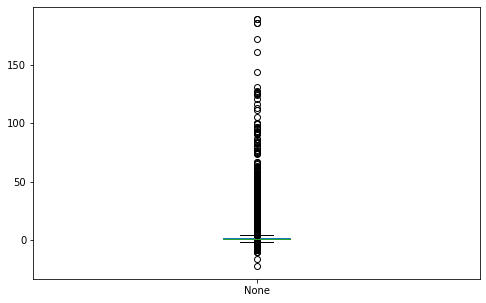

In [67]:
fig, ax = plt.subplots(figsize=(8, 5))
scores.plot(kind='box', ax=ax)
ax1.set_xticklabels(['Fisher score'])

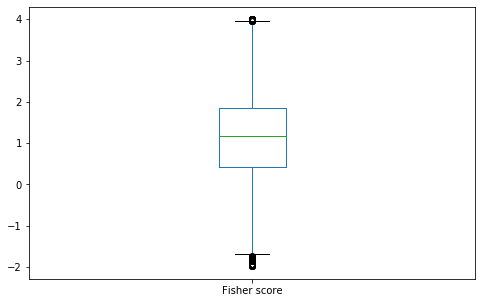

In [68]:
# zoom on scores between -2 and 4
# +/-log10(0.5) = +/- 1.3

fig, ax = plt.subplots(figsize=(8, 5))
scores[(scores > -2) & (scores < 4)].plot(kind='box', ax=ax)
ax.set_xticklabels(['Fisher score'])
plt.show()

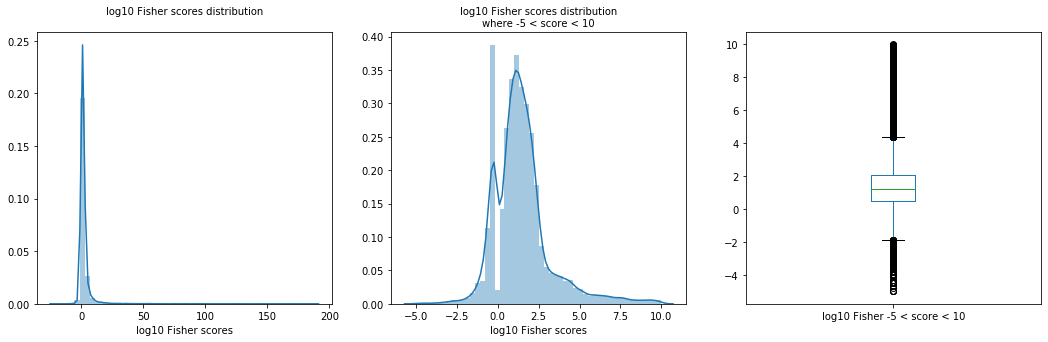

In [121]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

sns.distplot(scores, ax=ax1)
ax1.set_title('log10 Fisher scores distribution\n', size=10)
ax1.set_xlabel('log10 Fisher scores')

subset_scores = scores[(scores < 10) & (scores > -5)]
sns.distplot(subset_scores, ax=ax2)
ax2.set_xlabel('log10 Fisher scores')
ax2.set_title('log10 Fisher scores distribution\nwhere -5 < score < 10', size=10)

subset_scores.plot(kind='box', ax=ax3)
ax3.set_xticklabels(['log10 Fisher -5 < score < 10'])

savefig('fisher_score_dist.svg')
plt.show()

Note that the vast majority of the data falls between a score of $-2$ to $5$.

In [122]:
extreme_values = ((fisherdata > -2) & (fisherdata < 5)).any()

In [123]:
extreme_values.size

4045

In [96]:
extreme_values

T.appo→ יהוה.n1          True
T.Objc→ נתן.v1.qal       True
T.Objc→ עשׂה.v1.qal      True
T.coord→ בן.n1           True
T.Objc→ לקח.v1.qal       True
                         ... 
T.מן.Time→ נפל.v1.hif    True
T.Subj→ כבס.v1.piel      True
צל.n1.ב.PreC→ T.Subj     True
קום.v1.PreC→ T.Subj      True
T.Subj→ כסה.v1.hit       True
Length: 4045, dtype: bool

In [97]:
fisherdata.loc[:,extreme_values].T.head(20)

,בן.n1,מלך.n1,ארץ.n1,אלהים.n1,אישׁ.n1,יום.n1,עם.n1,בית.n1,פנה.n1,יד.n1,...,קצה.n2,עבר.n1,תמיד.n1,שׁקר.n1,מלכות.n1,מעל.n1,קדם.n1,מספר.n1,רב.n2,פאה.n1
T.appo→ יהוה.n1,-22.526176,-8.520539,-10.090639,188.586441,-10.062695,-6.834724,-10.442296,-8.874304,-6.808889,-8.013363,...,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.0
T.Objc→ נתן.v1.qal,-6.584308,-2.325327,13.203858,-5.609915,-3.578919,-4.760392,-1.131739,-0.821262,-0.301747,-0.680842,...,0.000000,0.0,0.0,0.00000,0.383579,0.0,0.0,0.000000,0.0,0.0
T.Objc→ עשׂה.v1.qal,-16.053631,-8.723371,-1.128023,-2.204913,-6.751329,-2.178418,-8.235782,-0.503675,-5.499925,-6.337739,...,0.000000,0.0,0.0,0.52901,0.000000,0.0,0.0,0.000000,0.0,0.0
T.coord→ בן.n1,185.876543,-6.924628,-7.365759,-8.241076,-3.087443,-4.975213,-3.228429,-2.997220,-4.956384,-6.014209,...,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.0
T.Objc→ לקח.v1.qal,-0.664666,-5.273685,-0.884072,-5.270503,1.878527,-3.968938,-2.173060,-3.155937,-3.956114,-4.628599,...,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.0
T.Subj→ אמר.v1.qal,-0.530167,78.554862,-4.623685,12.552682,9.497358,-3.980369,4.546116,-2.492384,-3.973536,-4.652064,...,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.0
T.Subj→ בוא.v1.qal,1.222394,3.889905,-2.876729,-0.702842,7.511183,1.349737,2.590030,-1.271517,-3.307627,-2.871512,...,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.0
T.ל.Cmpl→ נתן.v1.qal,1.975730,0.371990,-2.880341,-1.414605,0.870435,-2.632615,0.733592,0.139088,24.424565,-3.147162,...,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.0
T.Objc→ נשׂא.v1.qal,-4.095284,-3.819261,-3.489125,-3.817084,-3.481737,-2.280310,-1.845534,-3.152327,6.714989,5.654060,...,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.0,0.970157,0.0,0.0
T.Objc→ שׂים.v1.qal,-5.308037,-0.636749,-0.432857,-2.000357,-2.408077,-2.085931,-1.277935,-1.420897,7.676347,1.344360,...,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.0


In [98]:
fisherdata.columns.size

4045

##  Adjust scores 

In [100]:
fish_mean = fisherdata.copy()

def replace_score(score):
    if score < -2:
        return -2
    elif score > 5:
        return 5
    else:
        return score
    
fish_mean = fisherdata.apply(lambda x: pd.Series(replace_score(y) for y in x), result_type='broadcast')

In [101]:
fish_mean

,T.appo→ יהוה.n1,T.Objc→ נתן.v1.qal,T.Objc→ עשׂה.v1.qal,T.coord→ בן.n1,T.Objc→ לקח.v1.qal,T.Subj→ אמר.v1.qal,T.Subj→ בוא.v1.qal,T.ל.Cmpl→ נתן.v1.qal,T.Objc→ נשׂא.v1.qal,T.Objc→ שׂים.v1.qal,...,T.Subj→ יצג.v1.hof,T.Subj→ כאב.v1.qal,T.Subj→ כרע.v1.qal,T.מן.Cmpl→ תאר.v1.qal,T.מן.PreC→ הנה.Subj,T.מן.Time→ נפל.v1.hif,T.Subj→ כבס.v1.piel,צל.n1.ב.PreC→ T.Subj,קום.v1.PreC→ T.Subj,T.Subj→ כסה.v1.hit
בן.n1,-2.0,-2.0,-2.000000,5.0,-0.664666,-0.530167,1.222394,1.975730,-2.000000,-2.000000,...,0.0,0.0,0.000000,0.0,0.881457,0.0,0.000000,0.0,0.000000,0.0
מלך.n1,-2.0,-2.0,-2.000000,-2.0,-2.000000,5.000000,3.889905,0.371990,-2.000000,-0.636749,...,0.0,0.0,1.164404,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
ארץ.n1,-2.0,5.0,-1.128023,-2.0,-0.884072,-2.000000,-2.000000,-2.000000,-2.000000,-0.432857,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,1.206016,0.0
אלהים.n1,5.0,-2.0,-2.000000,-2.0,-2.000000,5.000000,-0.702842,-1.414605,-2.000000,-2.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
אישׁ.n1,-2.0,-2.0,-2.000000,-2.0,1.878527,5.000000,5.000000,0.870435,-2.000000,-2.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.0,1.203051,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
מעל.n1,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
קדם.n1,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
מספר.n1,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.970157,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
רב.n2,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0


In [102]:
fish_capped = fisherdata.copy()

def replace_score(score):
    if score < -1.3:
        return -1.3
    elif score > 1.3:
        return 1.3
    else:
        return score
    
fish_capped = fish_capped.apply(lambda x: pd.Series(replace_score(y) for y in x), result_type='broadcast')

fish_capped.head()

,T.appo→ יהוה.n1,T.Objc→ נתן.v1.qal,T.Objc→ עשׂה.v1.qal,T.coord→ בן.n1,T.Objc→ לקח.v1.qal,T.Subj→ אמר.v1.qal,T.Subj→ בוא.v1.qal,T.ל.Cmpl→ נתן.v1.qal,T.Objc→ נשׂא.v1.qal,T.Objc→ שׂים.v1.qal,...,T.Subj→ יצג.v1.hof,T.Subj→ כאב.v1.qal,T.Subj→ כרע.v1.qal,T.מן.Cmpl→ תאר.v1.qal,T.מן.PreC→ הנה.Subj,T.מן.Time→ נפל.v1.hif,T.Subj→ כבס.v1.piel,צל.n1.ב.PreC→ T.Subj,קום.v1.PreC→ T.Subj,T.Subj→ כסה.v1.hit
בן.n1,-1.3,-1.3,-1.300000,1.3,-0.664666,-0.530167,1.222394,1.300000,-1.3,-1.300000,...,0.0,0.0,0.000000,0.0,0.881457,0.0,0.000000,0.0,0.000000,0.0
מלך.n1,-1.3,-1.3,-1.300000,-1.3,-1.300000,1.300000,1.300000,0.371990,-1.3,-0.636749,...,0.0,0.0,1.164404,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
ארץ.n1,-1.3,1.3,-1.128023,-1.3,-0.884072,-1.300000,-1.300000,-1.300000,-1.3,-0.432857,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,1.206016,0.0
אלהים.n1,1.3,-1.3,-1.300000,-1.3,-1.300000,1.300000,-0.702842,-1.300000,-1.3,-1.300000,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
אישׁ.n1,-1.3,-1.3,-1.300000,-1.3,1.300000,1.300000,1.300000,0.870435,-1.3,-1.300000,...,0.0,0.0,0.000000,0.0,0.000000,0.0,1.203051,0.0,0.000000,0.0


## Comparing the Nouns

The nouns are now ready to be compared.

Principle Component Analysis — We have a semantic space with ~4k dimensions. That is a lot of potential angles from which to compare the vectors. One method that is commonly used in semantic space analysis is principle component analysis or **PCA**. PCA is a dimensionality reduction method that reduce a multi-dimensional vector to the two points in an imagined space that show the most distance between the nouns. We can visualize said space by plotting the two points on an X and Y axis.

### PCA Analysis

We want to apply PCA in order to plot nouns in an imaginary space. The goal is to use the visualization to identify patterns and groups amongst the 199 target nouns. Nouns that are more similar should fall within the same general areas relative to the origin (0, 0). PCA seeks to identify the maximum variance amongst the vector spaces. 

## Fisher with adjusted max/min scores

In [103]:
def plot_nouns(df, ax, family='serif', weight='heavy', **kwargs):
    for noun in df.index:
        x,y = df.loc[noun]
        lex, sp = noun.split('.')
        noun_text = get_display(lex).replace('\u05C1','')
        ax.text(x, y, noun_text, family=family, weight=weight, **kwargs)

fish_raw


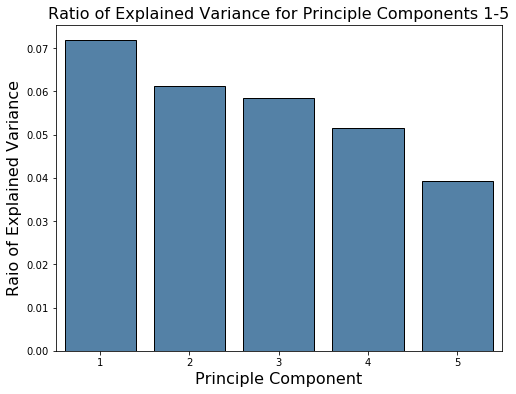

fish_capped


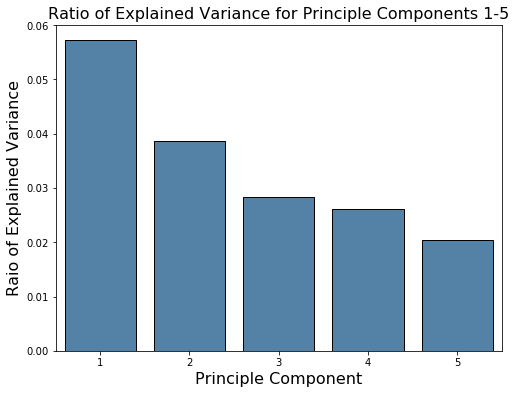

fish_mean


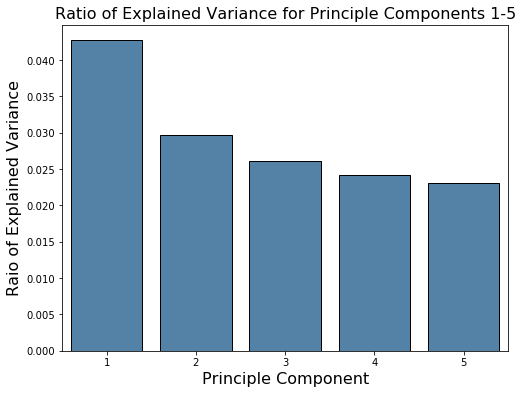

In [104]:
# store PCA experiments by normalization type
exp2pca = collections.defaultdict(dict)
experiments = {
    'fish_raw': fisherdata,
    'fish_capped': fish_capped,
    'fish_mean': fish_mean,
}

for exp_name, data in experiments.items():
    print(exp_name)
    
    pca_df, loadings_df = apply_pca(
        data,
        sample_axis=0,
        feature_axis=1,
        components=5
    )
    exp2pca[exp_name]['pca'] = pca_df.loc[:, :'PC2']
    exp2pca[exp_name]['loadings'] = loadings_df.iloc[:2].T

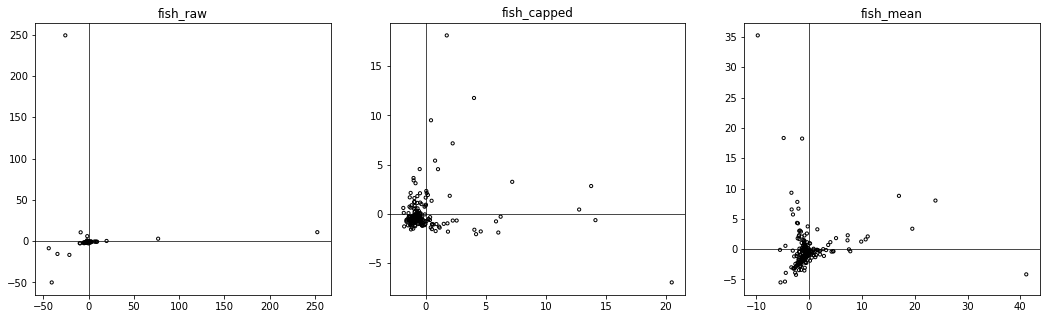

In [112]:
fig, axes = plt.subplots(1, 3, figsize=(18,5))

for x, ax in zip(exp2pca, axes):
    pca_df = exp2pca[x]['pca']
    ax.scatter(pca_df['PC1'], pca_df['PC2'], s=10, color='', edgecolor='black')
    ax.axhline(0, linewidth=0.7, color='black')
    ax.axvline(0, linewidth=0.7, color='black')
    ax.set_title(x)

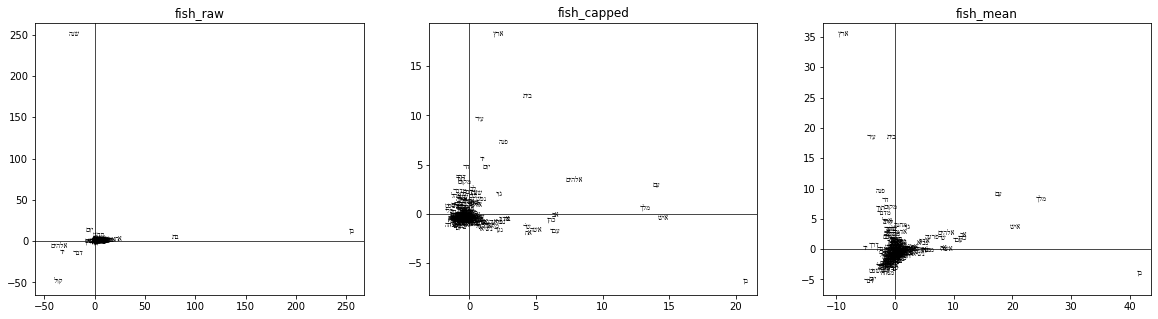

In [113]:
fig, axes = plt.subplots(1, 3, figsize=(20,5))

for x, ax in zip(exp2pca, axes):
    pca_df = exp2pca[x]['pca']
    ax.scatter(pca_df['PC1'], pca_df['PC2'], s=11, color='')
    plot_nouns(pca_df, ax, size=8)
    ax.axhline(0, linewidth=0.7, color='black')
    ax.axvline(0, linewidth=0.7, color='black')
    ax.set_title(x)
    
savefig('pca_text.svg')

# Examining Fish Mean

In [132]:
fm_pca = exp2pca['fish_mean']['pca']
fm_loads = exp2pca['fish_mean']['loadings']

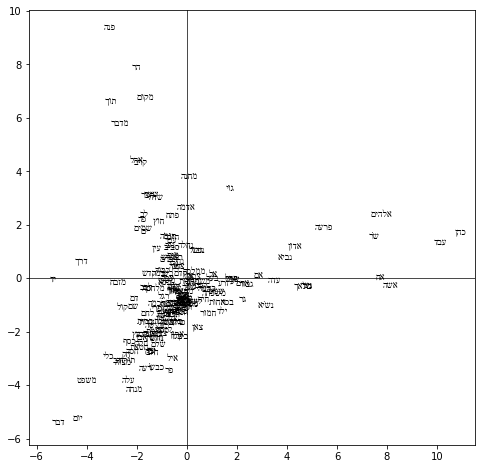

In [182]:
fm_pca_subset = fm_pca.loc[fm_pca.abs().max(1) < 11]
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(fm_pca_subset['PC1'], fm_pca_subset['PC2'], s=11, color='')
plot_nouns(fm_pca_subset, ax)
ax.axhline(0, linewidth=0.7, color='black')
ax.axvline(0, linewidth=0.7, color='black')
savefig('pca_fish_mean_zoomed.svg')

### Quadrant I

In [184]:
# terms in Q1

def sort_on_mean(df, axis=1):
    """Sort on the mean of the absolute value across rows"""
    return df.loc[df.abs().mean(axis).sort_values(ascending=False).index]
    
def get_quad(bound1, bound2, sort=True):
    words = fm_pca[(bound1) & (bound2)]
    if sort:
        words = sort_on_mean(words)
    return words

quad_1 = get_quad(fm_pca.PC1 > 0, fm_pca.PC2 > 0)
quad_1

,PC1,PC2
מלך.n1,23.927481,8.011745
עם.n1,17.017484,8.788191
אישׁ.n1,19.546282,3.365023
אב.n1,11.108502,2.093209
כהן.n1,10.716007,1.603413
עבד.n1,9.877423,1.242954
אלהים.n1,7.322791,2.283715
שׂר.n1,7.280463,1.449141
פרעה.n1,5.112540,1.813834
אדון.n1,4.036221,1.149682


In [169]:
# influences on Q1
def get_qloads(bound1, bound2, sort=True):
    loads = fm_loads[(bound1) & (bound2)]
    if sort:
        loads = sort_on_mean(loads)
    return loads

q1_loads = get_qloads(fm_loads[1] > 0, fm_loads[2] > 0)
q1_loads.head(20)

,1,2
T.Subj→ אמר.v1.qal,0.702014,0.010138
T.אל.Cmpl→ אמר.v1.qal,0.644976,0.047660
T.Subj→ שׁמע.v1.qal,0.388797,0.119804
T.אל.Cmpl→ דבר.v1.piel,0.483784,0.002720
T.ל.Cmpl→ אמר.v1.qal,0.413048,0.062463
T.coord→ עם.n1,0.259203,0.181011
T.Subj→ ענה.v1.qal,0.350956,0.088178
T.Subj→ הלך.v1.qal,0.408740,0.024061
T.appo→ יואשׁ.n1,0.369774,0.027550
T.ל.Cmpl→ נגד.v1.hif,0.302284,0.092158


In [170]:
# sort by influence on PC2
q1_loads.sort_values(by=2, ascending=False).head(10)

,1,2
T.ל.Cmpl→ עשׂה.v1.qal,0.152406,0.201384
T.coord→ עם.n1,0.259203,0.181011
T.coord→ מלך.n1,0.176594,0.162133
בית.n1.appo→ T,0.034534,0.150582
T.Objc→ נכה.v1.hif,0.104855,0.147779
T.אל.Cmpl→ ירד.v1.qal,0.019692,0.147629
T.עם.Cmpl→ עשׂה.v1.qal,0.041577,0.144750
T.Objc→ לכד.v1.qal,0.019189,0.143849
T.מן.Cmpl→ כרת.v1.nif,0.042492,0.140536
T.Objc→ ברך.v1.piel,0.117573,0.137267


### Quadrant IV

In [185]:
quad_4 = get_quad(fm_pca.PC1 > 0, fm_pca.PC2 < 0)

quad_4

,PC1,PC2
בן.n1,41.117329,-4.163155
אשׁה.n1,7.805224,-0.356257
אח.n1,7.556637,-0.035174
בת.n1,4.613895,-0.375907
נער.n1,4.560412,-0.337056
מלאך.n1,4.263777,-0.410916
נשׂיא.n1,2.820433,-1.123895
עדה.n1,3.237589,-0.159840
גר.n1,2.083633,-0.883883
אם.n1,2.681281,-0.000615


In [172]:
q4_loads = get_qloads(fm_loads[1] > 0, fm_loads[2] < 0)

q4_loads.head(20)

,1,2
T.Subj→ עשׂה.v1.qal,0.667444,-0.052823
T.Subj→ בוא.v1.qal,0.530268,-0.129341
T.appo→ בן.n1,0.480209,-0.171127
T.coord→ בן.n1,0.338842,-0.293266
בן.n1.appo→ T,0.254760,-0.240349
T.coord→ אשׁה.n1,0.379814,-0.102633
T.Objc→ צוה.v1.piel,0.377676,-0.057434
T.coord→ בת.n1,0.224943,-0.205657
T.Subj→ מות.v1.qal,0.380134,-0.032398
T.Subj→ יצא.v1.qal,0.297472,-0.088139


### Quadrant II

In [186]:
quad_2 = get_quad(fm_pca.PC1 < 0, fm_pca.PC2 > 0)

quad_2

,PC1,PC2
ארץ.n1,-9.703548,35.255264
עיר.n1,-4.803429,18.329517
בית.n1,-1.309249,18.237181
פנה.n1,-3.333220,9.298026
הר.n1,-2.215622,7.788545
תוך.n1,-3.291350,6.543304
מדבר.n1,-3.038673,5.713646
מקום.n1,-2.007593,6.681607
אהל.n1,-2.278033,4.330959
קרב.n1,-2.105495,4.257685


In [189]:
q2_loads = get_qloads(fm_loads[1] < 0, fm_loads[2] > 0)

q2_loads.head(20)

,1,2
T.ב.Cmpl→ ישׁב.v1.qal,-0.341608,0.598244
T.Cmpl→ בוא.v1.qal,-0.291847,0.496119
T.מן.Cmpl→ יצא.v1.qal,-0.273473,0.492924
T.אל.Cmpl→ בוא.v1.qal,-0.018130,0.709725
T.Objc→ נתן.v1.qal,-0.434498,0.231664
T.coord→ ארץ.n1,-0.225612,0.415797
T.ב.Loca→ עשׂה.v1.qal,-0.197892,0.403823
T.אל.Cmpl→ הלך.v1.qal,-0.113565,0.453418
T.מן.Cmpl→ יצא.v1.hif,-0.184430,0.350940
T.אל.Cmpl→ בוא.v1.hif,-0.097613,0.431742


### Quadrant III

In [177]:
quad_3 = get_quad(fm_pca.PC1 < 0, fm_pca.PC2 < 0)

quad_3.head(40)

,PC1,PC2
דבר.n1,-5.398880,-5.489957
יום.n1,-4.557159,-5.352868
משׁפט.n1,-4.401004,-3.916320
מנחה.n1,-2.466885,-4.240258
עלה.n1,-2.625215,-3.893145
כלי.n1,-3.353109,-3.001662
זהב.n1,-2.980360,-3.166385
מצוה.n1,-2.875876,-3.221640
תורה.n1,-2.719944,-3.151316
יד.n1,-5.496636,-0.123134


In [181]:
q3_loads = get_qloads(fm_loads[1] < 0, fm_loads[1] < 0)

q3_loads.head(20)

,1,2
T.Objc→ עשׂה.v1.qal,-0.589626,-0.643705
T.ב.Cmpl→ ישׁב.v1.qal,-0.341608,0.598244
T.Cmpl→ בוא.v1.qal,-0.291847,0.496119
T.מן.Cmpl→ יצא.v1.qal,-0.273473,0.492924
T.אל.Cmpl→ בוא.v1.qal,-0.018130,0.709725
T.Objc→ שׁמר.v1.qal,-0.383895,-0.333266
T.Objc→ נתן.v1.qal,-0.434498,0.231664
T.coord→ ארץ.n1,-0.225612,0.415797
T.ב.Loca→ עשׂה.v1.qal,-0.197892,0.403823
T.Objc→ שׁמע.v1.qal,-0.281428,-0.317321


In [179]:
# what of JWM?
# raw log10 fisher scores below
fisherdata.loc['יום.n1'].sort_values(ascending=False).head(20)

T.coord→ יום.n1           92.981393
T.Time→ עשׂה.v1.qal       55.532821
שׁנה.n1.PreC→ T.Subj      50.970399
T.Time→ ישׁב.v1.qal       35.582728
T.Time→ אכל.v1.qal        32.996013
T.ב.Time→ בוא.v1.qal      28.031306
בוא.v1.PreC→ T.Subj       27.880288
רב.n1.atr→ T              20.993281
T.ב.Time→ עשׂה.v1.qal     20.673154
T.ב.Time→ ראה.v1.qal      19.602881
T.Objc→ ארך.v1.hif        18.736186
T.ב.Time→ קרא.v1.qal      18.000324
T.ב.Time→ אמר.v1.qal      15.988987
T.ב.Time→ דבר.v1.piel     14.237331
T.עד.Time→ ישׁב.v1.qal    14.237331
T.ב.Time→ נתן.v1.qal      14.218784
T.Time→ נתן.v1.qal        13.179573
T.Time→ ירא.v1.qal        12.341912
T.ב.Time→ יצא.v1.qal      11.095608
T.ל.Time→ עשׂה.v1.qal     10.730478
Name: יום.n1, dtype: float64